# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [122]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [123]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=2000)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [124]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 4768, 'TN': 5585, 'FP': 4458, 'FN': 5189, 'Accuracy': 0.51765, 'Precision': 0.5168003468458704, 'Recall': 0.47885909410465, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [125]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [126]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [127]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9550, 'TN': 9876, 'FP': 167, 'FN': 407, 'Accuracy': 0.9713, 'Precision': 0.9828136256046105, 'Recall': 0.9591242342070905, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [128]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

class sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)

alpha reduces variance, fit_intercept calc the intercept(?), normalize will normalize before regression, copy_x, max_iter number of iterations, tol is the precision of the solution, class weight will change the weights of classes, solver uses different algorithms in computational routines.

In [129]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.3, tol=0.05, class_weight='balanced', solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9857, 'TN': 9933, 'FP': 110, 'FN': 100, 'Accuracy': 0.9895, 'Precision': 0.9889635798133841, 'Recall': 0.9899568143014964, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [130]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=50, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9734, 'TN': 9619, 'FP': 424, 'FN': 223, 'Accuracy': 0.96765, 'Precision': 0.9582594999015555, 'Recall': 0.9776036958923371, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

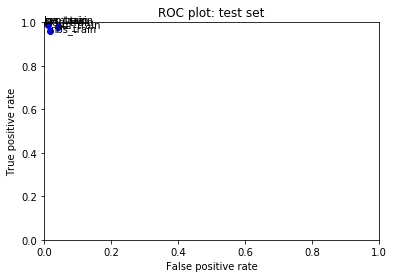

In [131]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [105]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [106]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
78
Note: I couldn't force myself to actually write up a constructive review of Prom Night. It just can't be done. Instead, I went through what I thought about while watching the movie.<br /><br />Things that I thought about while watching Prom Night: <br /><br />-I'm so tired of those dreams where these elaborate deaths will take place, only for the main character to wake up right before she bites it. Of course, when I say \elaborate deaths\", I mean off screen throat slashes or stabs in the stomach. Didn't the whole \"it's just a dream\" thing get ruined by Dallas? Speaking of which, I wonder if a couple stabs in the gut will cause immediate death.<br /><br />-The film is only ten minutes into and I can already count the horror clichés on two hands. Not a good sign.<br /><br />-Even after just meeting the protagonist's boyfriend, I'm convinced he will die. Anybody want to place bets? <br /><br />-The killer in this movie is a teacher that is obsessed with 

3776
There's not much to say about this one. Gammera is some kind of fire breathing turtle. He is loosed by a nuclear explosion. He heads for land and begins to destroy building and tanks and other junk (oh yeah, power lines. I almost forgot). At one time, early in the film, he befriends a little boy, and instead of just throwing him away, or squashing him, he places him down on the ground. Safe. From then on we have to watch this chubby faced little twerp show up and run away, show up and run away, show up and run away. For some reason, Gammera is able to hear this kid from 20,000 feet away. Oh, well, the plot is to try to get Gammera to get to a place where he can be put on board a rocket and shot into space. As usual, the monster is lumbering and uncoordinated (a guy in a Gammera suit). The Japanese army (with the help of Americans), uses up enough ammunition and fire power to solve the national debt, and, of course, it does no good. They should know this anyway. We've seen a lot of

7021
I ve finished seeing the movie 10 minutes ago..WoW i still cant believe what i've watched.<br /><br />This is absolutely the worst movie EVER. If i would list all the flaws in the movie , this review would take me a lot of sentences.( very funny flaws, because of being that bad though)<br /><br />You got to be Amazed with the skill of the commandos assigned to rescue the plane. they didn't even know how to move.<br /><br />Ice-t is so bad actor... and the thing i don't understand, is how the production wanted him to be like a hero, but he's a zero..<br /><br />of course the major flaws will be the landing of an 747, needing only 3 or 4 tips from a guy in transmission to land the plane...amazing.. as well as the dead bodys that had almost no blood at all..<br /><br />But i strongly recommend of watching this movie, as its very interesting to see how bad can something get
* * * * * * * * * 
7074
I agree with most of the other guys. A waste of photons and valuable time.<br /><br />Ne

11409
Rating: 4 out of 10<br /><br />As this mini-series approached, and we were well aware of it for the last six months as Sci-Fi Channel continued to pepper their shows with BG ads, I confess that I felt a growing unease as I learned more.<br /><br />As with any work of cinematic art which has stood up to some test of time, different people go to it to see different things. In this regard, when people think of Battlestar Galactica, they remember different things. For some it is the chromium warriors with the oscillating red light in their visor. For others, it is the fondness that they held for special effects that were quite evolutionary for their time. Many forget the state of special effects during the late 70s, especially those on television. For some the memories resolve around the story arc. Others still remember the relationships how how the relationships themselves helped overcome the challenges that they faced.<br /><br />Frankly, I come from the latter group. The core of B

14613
While exploring some caves with his wife, a doctor is bitten by a bat which causes some alarming side effects...<br /><br />Occasionally creepy atmosphere and some decent (though under used) makeup effects don't save this B horror flick from being a sub-par tale of man-becomes-creature. The Bat People aka It Lives By Night suffers from its senseless story that's awkwardly plotted and lackluster in pacing. The plot never seems to go anywhere much and the movie never offers an explanation for what happens, or even a satisfying conclusion for it all. The cast is fairly mediocre in their performances.<br /><br />Still I give the film some points for its haunting theme song and nice filming locations. The makeup work of the late Stan Winston is pretty good too, but it doesn't get much of a showcase here. A missed opportunity for sure. <br /><br />Definitely one of the lesser man-creature flicks out there.<br /><br />* 1/2 out of ****
* * * * * * * * * 
14645
I have been familiar with 

18264
Some fraud girl tries to compete in the big leagues of motorcross by swiching places with her brother. She gets to the top by lying and manipulation. She should have been disqualified. The movie promotes lying and cheating to win. also the idea of a 9 yr old mechanic is absurd. it takes many many years to get good. Go back to the tonka toys.
* * * * * * * * * 
18276
I love special effects and witnessing new technologies that make science fiction seem real. The special effects of this movie are very good. I have seen most of this movie, since it's been airing on HBO for the past couple of months. I must admit, I MAY have missed a few scenes, but I'm usually drawn into movies, and have seen some scenes more than once. But every time I see some of \Hollow Man,\" I feel depressed, almost like a \"film noir.\" I'm not sure why; perhaps it's that I don't want Kevin Bacon to be evil, and there's disappointment in that. But I think it's witnessing just HOW relentlessly evil he becomes. R

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [107]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1083, 'TN': 1507, 'FP': 950, 'FN': 1460, 'Accuracy': 0.518, 'Precision': 0.5327102803738317, 'Recall': 0.4258749508454581, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [108]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2159, 'TN': 2063, 'FP': 394, 'FN': 384, 'Accuracy': 0.8444, 'Precision': 0.8456717587152369, 'Recall': 0.8489972473456547, 'desc': 'svm_test'}


### MODEL: logistic regression

In [109]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2137, 'TN': 2060, 'FP': 397, 'FN': 406, 'Accuracy': 0.8394, 'Precision': 0.8433307024467246, 'Recall': 0.8403460479748329, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [110]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1913, 'TN': 1834, 'FP': 623, 'FN': 630, 'Accuracy': 0.7494, 'Precision': 0.7543375394321766, 'Recall': 0.7522611089264648, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [111]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2181, 'TN': 2059, 'FP': 398, 'FN': 362, 'Accuracy': 0.848, 'Precision': 0.8456766188445134, 'Recall': 0.8576484467164766, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [133]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2315, 'TN': 2175, 'FP': 282, 'FN': 228, 'Accuracy': 0.898, 'Precision': 0.8914131690412014, 'Recall': 0.9103421156114825, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [134]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1885, 'TN': 1796, 'FP': 661, 'FN': 658, 'Accuracy': 0.7362, 'Precision': 0.7403770620581304, 'Recall': 0.7412504915454188, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

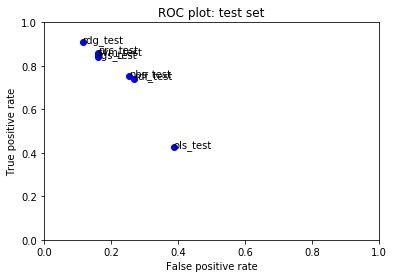

In [135]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [115]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=200, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [116]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49628


In [117]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation